## GAAIMS: Predicting Multiple Sclerosis from Dynamics of Gait Variability Using an Instrumented Treadmill - A Machine Learning-Based Approach

### Person generalization ML models and analysis


### Package imports 

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import xgboost 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from inspect import signature
from scipy import interp
from pyitlib import discrete_random_variable as drv
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings("ignore")

In [3]:
path = 'C:\\Users\\rk4\\Dropbox\\GAIT\\sample_data\\data_export\\'

In [4]:
#Reading the raw dataframe 
raw_df = pd.read_csv(path+'..\\..\\FinalCodes\\gait_features.csv', index_col = 0)
#Dropping the NaNs
raw_df.dropna(inplace = True)
#Resetting the index
raw_df.reset_index(inplace= True)
print ('Raw data shape: ', raw_df.shape)

#Reading the Size-N dataframe 
sizeN_df = pd.read_csv(path+'..\\..\\FinalCodes\\size_normalized_gait_features.csv', index_col = 0)
#Dropping the NaNs
sizeN_df.dropna(inplace = True)
#Resetting the index
sizeN_df.reset_index(inplace= True)
print ('Size-N data shape: ', sizeN_df.shape)

#Reading the Regress-N dataframe 
regressN_df = pd.read_csv(path+'..\\..\\FinalCodes\\mr_scaled_features_30controlsTrialW.csv', index_col = 0)
regressN_df.reset_index(inplace= True)
print('Regress-N data shape: ', regressN_df.shape)

#Delete the treadmill speeds as features since they are very very correlated with stride speed
#Also delete Butterfly plot y-direction features since COP_Y is not adjusted 
#Swing time and SS_L are the same
to_drop = ['tspeed_HSR', 'tspeed_MidSSR', 'tspeed_TOR', 'tspeed_HSL', 'tspeed_TOL', 'tspeed_MidSSL',  'Butterfly_y_abs', 
           'ButterflySQ_y', 'SS_L', 'index']
raw_df.drop(to_drop, axis = 1, inplace= True)
raw_df = shuffle(raw_df, random_state = 0)
print ('Raw data shape: ', raw_df.shape) #21 features + PID + Trial ID + Label = 24 features 

sizeN_df.drop(to_drop, axis = 1, inplace= True)
sizeN_df = shuffle(sizeN_df, random_state = 0)
print ('Size-N data shape: ', sizeN_df.shape) #21 features + PID + Trial ID + Label = 24 features 

regressN_df.drop(['index'], axis = 1, inplace = True)
regressN_df = shuffle(regressN_df, random_state = 0)
print('Regress-N data shape: ', regressN_df.shape)  #21 features + PID + Trial ID + Label = 24 features 

Raw data shape:  (3230, 34)
Size-N data shape:  (3230, 34)
Regress-N data shape:  (3230, 25)
Raw data shape:  (3230, 24)
Size-N data shape:  (3230, 24)
Regress-N data shape:  (3230, 24)


### Evaluation

In [5]:
def evaluate(model, test_features, yoriginal_, ypredicted_):
    best_index = model.cv_results_['mean_test_accuracy'].argmax()
    print('best_params: ', model.cv_results_['params'][best_index])

    #Stride-wise metrics 
    stride_metrics_mean, stride_metrics_std = [], [] #Mean and SD of stride based metrics - Acc, P, R, F1, AUC (in order)
    scores={'accuracy': make_scorer(acc), 'precision':'precision', 'recall':'recall', 'f1': 'f1', 'auc': 'roc_auc'}
    for score in scores:
        stride_metrics_mean.append(model.cv_results_['mean_test_'+score][best_index])
        stride_metrics_std.append(model.cv_results_['std_test_'+score][best_index])
    print('Stride-based model performance (mean): ', stride_metrics_mean)
    print('Stride-based model performance (standard deviation): ', stride_metrics_std)
    n_folds = 7
    person_acc, person_p, person_r, person_f1, person_auc = [], [], [], [], []
    #For ROC curves 
    tpr_list = []
    base_fpr = np.linspace(0, 1, 101)

    for i in range(n_folds):
        #For each fold, there are 2 splits: test and train (in order) and we need to retrieve the index 
        #of only test set for required 5 folds (best index)
        temp = test_features.loc[yoriginal_[(best_index*10) + (2*i)].index] #True labels for the test strides in each fold
        temp['pred'] = ypredicted_[(best_index*10) + (2*i)] #Predicted labels for the strides in the test set in each fold

        #Correctly classified strides i.e. 1 if stride is correctly classified and 0 if otherwise
        temp['correct'] = (temp['Label']==temp['pred'])

        #Proportion of correctly classified strides
        proportion_strides_correct = temp.groupby('PID').aggregate({'correct': 'mean'})  

        proportion_strides_correct['True Label'] = temp[['PID', 'Label']].groupby('PID').first() 

        #Label for the person - 0=healthy, 1=MS patient
        proportion_strides_correct['Predicted Label'] = proportion_strides_correct['True Label']*\
        (proportion_strides_correct['correct']>0.5)+(1-proportion_strides_correct['True Label'])*\
        (proportion_strides_correct['correct']<0.5) 

        #Probability of class 1 - MS patient for AUC calculation
        proportion_strides_correct['prob_class1'] = (1-proportion_strides_correct['True Label'])*\
        (1-proportion_strides_correct['correct'])+ proportion_strides_correct['True Label']*proportion_strides_correct['correct'] 

        fpr, tpr, _ = roc_curve(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1'])
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tpr_list.append(tpr)

        #Person wise metrics for each fold 
        person_acc.append(accuracy_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_p.append(precision_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_r.append(recall_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_f1.append(f1_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_auc.append(roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1']))

    #Mean and standard deviation for person-based metrics 
    person_means = [np.mean(person_acc), np.mean(person_p), np.mean(person_r), np.mean(person_f1), np.mean(person_auc)]
    person_stds = [np.std(person_acc), np.std(person_p), np.std(person_r), np.std(person_f1), np.std(person_auc)]
    print('Person-based model performance (mean): ', person_means)
    print('Person-based model performance (standard deviation): ', person_stds)

    return tpr_list, [stride_metrics_mean, stride_metrics_std, person_means, person_stds]

### ML models 

In [6]:
def acc(y_true,y_pred):
    global yoriginal, ypredicted
    yoriginal.append(y_true)
    ypredicted.append(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [7]:
#We do not use LDA/QDA since our features are not normally distributed 
def models(X, Y, model_name = 'random_forest'):
    '''
    X, Y, PID groups so that strides of each person are either in training or in testing set
    model: model_name
    '''
    Y_ = Y['Label'] #Dropping the PID
    groups_ = Y['PID']
    gkf = GroupKFold(n_splits=7) 
    scores={'accuracy': make_scorer(acc), 'precision':'precision', 'recall':'recall', 'f1': 'f1', 'auc': 'roc_auc'}
    
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'randomforestclassifier__n_estimators': [40,45,50],\
       'randomforestclassifier__max_depth' : [15,20,25,None],\
       'randomforestclassifier__class_weight': [None, 'balanced'],\
       'randomforestclassifier__max_features': ['auto','sqrt','log2', None],\
       'randomforestclassifier__min_samples_leaf':[1,2,0.1,0.05]
        }
        #For z-score scaling on training and use calculated coefficients on test set
        rf_grid = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0))
        grid_search = GridSearchCV(rf_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=0))
        grid = {
        'adaboostclassifier__n_estimators':[50, 75, 100, 125, 150],\
        'adaboostclassifier__learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = make_pipeline(StandardScaler(), SVC(kernel = 'rbf', probability=True, random_state=0))
        grid = {
        'svc__gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    if(model_name == 'gbm'): #GBM
        gbm_grid = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
        grid = {
        'gradientboostingclassifier__learning_rate':[0.15,0.1,0.05], \
        'gradientboostingclassifier__n_estimators':[50, 100, 150],\
        'gradientboostingclassifier__max_depth':[2,4,7],\
        'gradientboostingclassifier__min_samples_split':[2,4], \
        'gradientboostingclassifier__min_samples_leaf':[1,3],\
        'gradientboostingclassifier__max_features':['auto','sqrt','log2', None],\
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = make_pipeline(StandardScaler(), xgboost.XGBClassifier(random_state=0))
        grid = {
            'xgbclassifier__min_child_weight': [1, 5],\
            'xgbclassifier__gamma': [0.1, 0.5, 1, 1.5, 2],\
            'xgbclassifier__subsample': [0.6, 0.8, 1.0],\
            'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],\
            'xgbclassifier__max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'knn'): #KNN
        knn_grid = make_pipeline(StandardScaler(), KNeighborsClassifier())
        grid = {
            'kneighborsclassifier__n_neighbors': [1, 3, 4, 5, 10],\
            'kneighborsclassifier__p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=0))
        #For z-score scaling on training and use calculated coefficients on test set
        grid = {'decisiontreeclassifier__min_samples_split': range(2, 50)}
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = make_pipeline(StandardScaler(), LinearSVC(random_state=0))
        grid = {
            'linearsvc__loss': ['hinge','squared_hinge'],\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        lr_grid = make_pipeline(StandardScaler(), LogisticRegression())
        grid = {
            'logisticregression__random_state': [0]}
            
        grid_search = GridSearchCV(lr_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    grid_search.fit(X, Y_, groups=groups_) #Fitting on the training set to find the optimal hyperparameters 
    tpr_list, stride_person_metrics = evaluate(grid_search, Y, yoriginal, ypredicted)
    return tpr_list, stride_person_metrics

### Raw data

In [9]:
#CV for people generalize so no train-test split
X_raw = raw_df.drop(['Label', 'PID', 'TrialID'], axis = 1)
Y_raw = raw_df[['PID', 'Label']] #PID to compute person based metrics later 

#How to make sure test set has equal no. of MS and controls in each split??

In [10]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression']
raw_metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for class 1) to show ROC curves 
tprs_raw = pd.DataFrame(columns = ml_models) 

for ml_model in ml_models:
    print (ml_model)
    yoriginal = []
    ypredicted = []
    tprs, stride_person_metrics = models(X_raw, Y_raw, ml_model)
    raw_metrics[ml_model] = sum(stride_person_metrics, [])
    tprs_raw[ml_model] = list(tprs)
    print ('********************************')

raw_metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
                     'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
                     'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
                     'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
                     'person_std_AUC']  
raw_metrics.to_csv(path+'..//person_generalize//person_generalize_results_raw_data.csv')
tprs_raw.to_csv(path+'..//person_generalize//person_generalize_ROCresults_raw_data.csv')

random_forest
best_params:  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 40}
Stride-based model performance (mean):  [0.5117647058823529, 0.4836297261829542, 0.518844067679779, 0.458252822245509, 0.5941741076105664]
Stride-based model performance (standard deviation):  [0.1278993109430925, 0.20581814451178215, 0.2278572357961582, 0.13239793177987522, 0.18258704346631968]
Person-based model performance (mean):  [0.4857142857142857, 0.4047619047619047, 0.4047619047619047, 0.3761904761904762, 0.4166666666666667]
Person-based model performance (standard deviation):  [0.09897433186107868, 0.31943828249996997, 0.31943828249997, 0.2586376307428623, 0.1336306209562122]
********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 100}
Stride-b

In [11]:
raw_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression
stride_mean_accuracy,0.511765,0.490093,0.563467,0.522601,0.514551,0.543963,0.484830,0.466873,0.469040
stride_mean_precision,0.483630,0.472321,0.532817,0.479421,0.480232,0.511731,0.442283,0.468145,0.470584
stride_mean_recall,0.518844,0.488313,0.039938,0.488577,0.506207,0.554681,0.502105,0.368143,0.374816
stride_mean_F1,0.458253,0.432105,0.070601,0.450438,0.450044,0.499242,0.433735,0.344047,0.347896
stride_mean_AUC,0.594174,0.576706,0.504515,0.570926,0.589477,0.571925,0.519265,0.556932,0.565288
stride_std_accuracy,0.127899,0.087511,0.183210,0.084758,0.084302,0.089218,0.068878,0.094131,0.097581
stride_std_precision,0.205818,0.196538,0.470169,0.191570,0.195534,0.164059,0.187482,0.278646,0.276787
stride_std_recall,0.227857,0.197370,0.061276,0.185783,0.217546,0.154520,0.190981,0.206131,0.211056
stride_std_F1,0.132398,0.063791,0.105277,0.095643,0.096736,0.081938,0.112553,0.132836,0.138188
stride_std_AUC,0.182587,0.163529,0.139471,0.171212,0.170178,0.079444,0.082814,0.188085,0.193134


### Size-N data

In [12]:
#CV for people generalize so no train-test split
X_sizeN = sizeN_df.drop(['Label', 'PID', 'TrialID'], axis = 1)
Y_sizeN = sizeN_df[['PID', 'Label']] #PID to compute person based metrics later 

In [13]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression']
sizeN_metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for class 1) to show ROC curves 
tprs_sizeN = pd.DataFrame(columns = ml_models) 

for ml_model in ml_models:
    print (ml_model)
    yoriginal = []
    ypredicted = []
    tprs, stride_person_metrics = models(X_sizeN, Y_sizeN, ml_model)
    sizeN_metrics[ml_model] = sum(stride_person_metrics, [])
    tprs_sizeN[ml_model] = tprs
    print ('********************************')

sizeN_metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
                     'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
                     'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
                     'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
                     'person_std_AUC']  
sizeN_metrics.to_csv(path+'..//person_generalize//person_generalize_results_sizeN_data.csv')
tprs_sizeN.to_csv(path+'..//person_generalize//person_generalize_ROCresults_sizeN_data.csv')

random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 45}
Stride-based model performance (mean):  [0.5325077399380805, 0.5467159264712569, 0.41806247182009393, 0.4077298668856502, 0.6346717589152133]
Stride-based model performance (standard deviation):  [0.160240062750555, 0.27522008824702576, 0.24173621474229748, 0.1927309468223988, 0.22667727375971938]
Person-based model performance (mean):  [0.5714285714285714, 0.5476190476190476, 0.5476190476190477, 0.5142857142857142, 0.6904761904761905]
Person-based model performance (standard deviation):  [0.24907993963089564, 0.329914439536929, 0.3417309546287458, 0.2948538205792899, 0.27355060221609656]
********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 75}
Stride-ba

In [14]:
sizeN_metrics.to_csv(path+'..//person_generalize//person_generalize_results_sizeN_data.csv')

In [15]:
sizeN_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression
stride_mean_accuracy,0.532508,0.591641,0.617028,0.538390,0.521981,0.500929,0.504334,0.492570,0.491022
stride_mean_precision,0.546716,0.594628,0.694181,0.557031,0.541761,0.479639,0.500278,0.487255,0.488096
stride_mean_recall,0.418062,0.439677,0.183343,0.453330,0.463569,0.261624,0.459387,0.379612,0.377759
stride_mean_F1,0.407730,0.451292,0.285803,0.434273,0.432798,0.295072,0.427290,0.382216,0.381761
stride_mean_AUC,0.634672,0.644395,0.537296,0.616867,0.600550,0.499462,0.537623,0.563126,0.561606
stride_std_accuracy,0.160240,0.151460,0.128310,0.175165,0.164796,0.120160,0.118726,0.168513,0.167620
stride_std_precision,0.275220,0.228468,0.284092,0.286812,0.280425,0.262922,0.249590,0.306060,0.306908
stride_std_recall,0.241736,0.240017,0.111892,0.245981,0.234659,0.132163,0.195765,0.218655,0.213890
stride_std_F1,0.192731,0.192090,0.160358,0.204272,0.191811,0.126529,0.145933,0.189702,0.185799
stride_std_AUC,0.226677,0.178991,0.224345,0.218804,0.216092,0.116557,0.120990,0.227465,0.225961


### Regress-N data

In [16]:
#CV for people generalize so no train-test split
X_regressN = regressN_df.drop(['Label', 'PID', 'TrialID'], axis = 1)
Y_regressN = regressN_df[['PID', 'Label']] #PID to compute person based metrics later 

In [17]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression']
regressN_metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for class 1) to show ROC curves 
tprs_regressN = pd.DataFrame(columns = ml_models) 

for ml_model in ml_models:
    print (ml_model)
    yoriginal = []
    ypredicted = []
    tprs, stride_person_metrics = models(X_regressN, Y_regressN, ml_model)
    regressN_metrics[ml_model] = sum(stride_person_metrics, [])
    tprs_regressN[ml_model] = tprs
    print ('********************************')

regressN_metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
                     'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
                     'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
                     'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
                     'person_std_AUC']  
regressN_metrics.to_csv(path+'..//person_generalize//person_generalize_results_regressN_data.csv')
tprs_regressN.to_csv(path+'..//person_generalize//person_generalize_ROCresults_regressN_data.csv')

random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 40}
Stride-based model performance (mean):  [0.5634674922600619, 0.5572740467577204, 0.4634600243138562, 0.4493397634700566, 0.6430360432018959]
Stride-based model performance (standard deviation):  [0.10781215367645426, 0.24601935580529496, 0.2286733685766013, 0.15696998077003999, 0.15894672496642792]
Person-based model performance (mean):  [0.6, 0.5238095238095238, 0.5714285714285714, 0.519047619047619, 0.6428571428571429]
Person-based model performance (standard deviation):  [0.18516401995451032, 0.27355060221609656, 0.3194382824999699, 0.23694962484999485, 0.18747637795266214]
********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 100}
Stride-based model pe

In [18]:
regressN_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression
stride_mean_accuracy,0.563467,0.586378,0.617028,0.583591,0.569040,0.569040,0.541176,0.549226,0.549536
stride_mean_precision,0.557274,0.561866,0.692137,0.580469,0.555360,0.579146,0.526271,0.496520,0.501601
stride_mean_recall,0.463460,0.431836,0.183064,0.518214,0.481385,0.347025,0.511525,0.402383,0.404906
stride_mean_F1,0.449340,0.459241,0.283911,0.486136,0.451946,0.392983,0.467252,0.404028,0.407264
stride_mean_AUC,0.643036,0.598396,0.524194,0.654395,0.641688,0.618629,0.596623,0.573460,0.596744
stride_std_accuracy,0.107812,0.097567,0.121181,0.121526,0.143607,0.136179,0.083191,0.160884,0.141773
stride_std_precision,0.246019,0.282111,0.230969,0.235111,0.269965,0.225404,0.215023,0.320536,0.306754
stride_std_recall,0.228673,0.186330,0.099436,0.234774,0.267541,0.161802,0.190565,0.288793,0.267422
stride_std_F1,0.156970,0.170762,0.139412,0.167145,0.215709,0.140324,0.114840,0.245522,0.219599
stride_std_AUC,0.158947,0.188512,0.191024,0.139616,0.158819,0.102043,0.107491,0.231287,0.209952


### ROC curves

In [134]:
sizeN_metrics = pd.read_csv(path+'..//person_generalize//person_generalize_results_sizeN_data.csv')
sizeN_metrics.index = sizeN_metrics['Unnamed: 0']
sizeN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

regressN_metrics = pd.read_csv(path+'..//person_generalize//person_generalize_results_regressN_data.csv')
regressN_metrics.index = regressN_metrics['Unnamed: 0']
regressN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

#Calculated from a different code so added here 
sizeN_metrics['mlp'] = len(sizeN_metrics)*[0]
sizeN_metrics['mlp'].loc['person_mean_AUC'] = 0.762
sizeN_metrics['mlp'].loc['person_std_AUC'] = 0.28

regressN_metrics['mlp'] = len(sizeN_metrics)*[0]
regressN_metrics['mlp'].loc['person_mean_AUC'] = 0.857
regressN_metrics['mlp'].loc['person_std_AUC'] = 0.23

In [135]:
sizeN_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
Unnamed: 0,,,,,,,,,,
stride_mean_accuracy,0.532508,0.591641,0.617028,0.538390,0.521981,0.500929,0.504334,0.492570,0.491022,0.000
stride_mean_precision,0.546716,0.594628,0.694181,0.557031,0.541761,0.479639,0.500278,0.487255,0.488096,0.000
stride_mean_recall,0.418062,0.439677,0.183343,0.453330,0.463569,0.261624,0.459387,0.379612,0.377759,0.000
stride_mean_F1,0.407730,0.451292,0.285803,0.434273,0.432798,0.295072,0.427290,0.382216,0.381761,0.000
stride_mean_AUC,0.634672,0.644395,0.537296,0.616867,0.600550,0.499462,0.537623,0.563126,0.561606,0.000
stride_std_accuracy,0.160240,0.151460,0.128310,0.175165,0.164796,0.120160,0.118726,0.168513,0.167620,0.000
stride_std_precision,0.275220,0.228468,0.284092,0.286812,0.280425,0.262922,0.249590,0.306060,0.306908,0.000
stride_std_recall,0.241736,0.240017,0.111892,0.245981,0.234659,0.132163,0.195765,0.218655,0.213890,0.000
stride_std_F1,0.192731,0.192090,0.160358,0.204272,0.191811,0.126529,0.145933,0.189702,0.185799,0.000


In [136]:
tprs_sizeN = pd.read_csv(path+'..//person_generalize//person_generalize_ROCresults_sizeN_data.csv')
tprs_sizeN.index = tprs_sizeN['Unnamed: 0']
tprs_sizeN.drop('Unnamed: 0', axis = 1, inplace = True)

tprs_regressN = pd.read_csv(path+'..//person_generalize//person_generalize_ROCresults_regressN_data.csv')
tprs_regressN.index = tprs_regressN['Unnamed: 0']
tprs_regressN.drop('Unnamed: 0', axis = 1, inplace = True)

tprs_sizeN_MLP = pd.read_csv(path+'..//person_generalize//tprs_person_generalize_ROCresults_sizeN_MLP.csv')
tprs_sizeN_MLP.index = tprs_sizeN_MLP['Unnamed: 0']
tprs_sizeN_MLP.drop('Unnamed: 0', axis = 1, inplace = True)

tprs_regressN_MLP = pd.read_csv(path+'..//person_generalize//tprs_MLP_cohortgeneralize_regressN.csv')
tprs_regressN_MLP.index = tprs_regressN_MLP['Unnamed: 0']
tprs_regressN_MLP.drop('Unnamed: 0', axis = 1, inplace = True)

In [137]:
ml_models1 = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression']

for model in ml_models1:
    for idx in range(7):
#         print (model, idx)
        tprs_sizeN[model][idx] = np.array(list(map(float, tprs_sizeN[model][idx][1:-1].split())))
        tprs_regressN[model][idx] = np.array(list(map(float, tprs_regressN[model][idx][1:-1].split())))


#Adding MLP to the column of tprs 
tprs_sizeN['mlp'] = [tprs_sizeN_MLP.iloc[0].values, tprs_sizeN_MLP.iloc[1].values, tprs_sizeN_MLP.iloc[2].values, \
                        tprs_sizeN_MLP.iloc[3].values, tprs_sizeN_MLP.iloc[4].values, tprs_sizeN_MLP.iloc[5].values, \
                        tprs_sizeN_MLP.iloc[6].values]

tprs_regressN['mlp'] = [tprs_regressN_MLP.iloc[0].values, tprs_regressN_MLP.iloc[1].values, tprs_regressN_MLP.iloc[2].values, \
                        tprs_regressN_MLP.iloc[3].values, tprs_regressN_MLP.iloc[4].values, tprs_regressN_MLP.iloc[5].values, \
                        tprs_regressN_MLP.iloc[6].values]

In [138]:
tprs_sizeN.head()

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
Unnamed: 0,,,,,,,,,,
0,"[0.0, 0.33333333, 0.33333333, 0.33333333, 0.33...","[0.0, 0.66666667, 0.66666667, 0.66666667, 0.66...","[0.0, 0.33333333, 0.33333333, 0.33333333, 0.33...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.33333333, 0.33333333, 0.33333333, 0.33...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75...",[0. 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",[0. 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 ...,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[0. 0. 0. 0. 0...,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.7525, 0.755, 0.7575, 0.76, 0.7625, 0.7...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


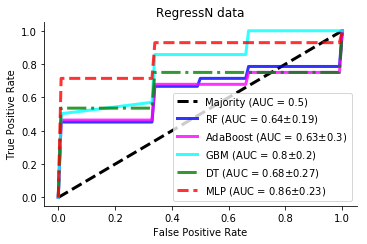

In [187]:
base_fpr = np.linspace(0, 1, 101)
ml_models = ['random_forest', 'adaboost', 'gbm', 'decision_tree', 'mlp'] #'knn'
ml_model_names = {'random_forest': 'RF', 'adaboost': 'AdaBoost', 'kernel_svm': 'RBF SVM', 'gbm': 'GBM', \
                  'xgboost': 'Xgboost', 'knn': 'KNN', 'decision_tree': 'DT',  'linear_svm': 'LSVM', 
             'logistic_regression': 'LR', 'mlp':'MLP'}

fig, axes = plt.subplots(1, 1, sharex=True, sharey = True, figsize=(5.2, 3.5))
sns.despine(offset=0)

linestyles = ['-', '-', '-', '-.', '--', '-', '--', '-', '--']
colors = ['b', 'magenta', 'cyan', 'g',  'red', 'violet', 'lime', 'grey', 'pink']

# #Raw Data 
# axes[0].plot([0, 1], [0, 1], linestyle='--', label='Majority (AUC = 0.5)', linewidth = 2, color = 'k')
# for ml_model in ml_models:
#     tprs = tprs_raw[ml_model] # person-based prediction probabilities
#     tprs = np.array(tprs)
#     mean_tprs = tprs.mean(axis=0)
#     std = tprs.std(axis=0)

#     tprs_upper = np.minimum(mean_tprs + std, 1)
#     tprs_lower = mean_tprs - std
#     axes[0].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
#     axes[0].plot(base_fpr, mean_tprs, label=ml_model_names[ml_model]+' (AUC = '+ str(round(raw_metrics.loc['person_mean_AUC']
#                      [ml_model], 2)) + r'$\pm$' + str(round(raw_metrics.loc['person_std_AUC']
#                      [ml_model], 2)) + ')', linewidth = 2)
# axes[0].set_ylabel('True Positive Rate')
# axes[0].legend(loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)
# axes[0].set_title('Raw data')

#SizeN Data 
# axes[0].plot([0, 1], [0, 1], linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
# for idx, ml_model in enumerate(ml_models):
#     tprs = tprs_sizeN[ml_model] # person-based prediction probabilities
#     tprs = np.array(tprs)
#     mean_tprs = tprs.mean(axis=0)
#     std = tprs.std(axis=0)

#     tprs_upper = np.minimum(mean_tprs + std, 1)
#     tprs_lower = mean_tprs - std
# #     axes[1].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
#     axes[0].plot(base_fpr, mean_tprs, label=ml_model_names[ml_model]+' (AUC = '+ str(round(sizeN_metrics.loc['person_mean_AUC']
#                      [ml_model], 2)) + r'$\pm$' + str(round(sizeN_metrics.loc['person_std_AUC']
#                      [ml_model], 2)) + ')', linewidth = 3, alpha = 0.8, linestyle = linestyles[idx], color = colors[idx])
# axes[0].legend() #loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)
# axes[0].set_ylabel('True Positive Rate')
# axes[0].set_title('SizeN data')

#RegressN Data 
axes.plot([0, 1], [0, 1], linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
for idx, ml_model in enumerate(ml_models):
    tprs = tprs_regressN[ml_model] # person-based prediction probabilities
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
#     axes[2].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    axes.plot(base_fpr, mean_tprs, label=ml_model_names[ml_model]+' (AUC = '+ str(round(regressN_metrics.loc['person_mean_AUC']
                     [ml_model], 2)) + r'$\pm$' + str(round(regressN_metrics.loc['person_std_AUC']
                     [ml_model], 2)) + ')', linewidth = 3, alpha = 0.8, linestyle = linestyles[idx], color = colors[idx])
axes.set_ylabel('True Positive Rate')
axes.set_title('RegressN data')
axes.legend() #loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)

axes.set_xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig(path + '..//person_generalize//ROC_person_generalize_onlyregressNdata.png', dpi = 250)
plt.show()